# Overfit and underfit

与往常一样，此示例中的代码将使用 [`tf.keras`](https://www.tensorflow.org/api_docs/python/tf/keras) API，您可以在 [TensorFlow Keras 指南](https://www.tensorflow.org/guide/keras)中了解更多信息。

在前面的两个例子中——[文本分类](2.基本文本分类.ipynb)和[燃料效率预测](4.回归.ipynb)——验证数据上的模型的准确性会在训练多个 epoch 后达到峰值，然后停滞或开始下降。

换句话说，您的模型会_过度拟合_训练数据。学习如何处理过拟合很重要。尽管通常可以在_训练集_上实现高精度，但您真正想要的是开发能够很好地泛化到_测试集_（或他们以前从未见过的数据）的模型。

过拟合的反义词是欠拟合。当训练数据仍有改进空间时，就会出现欠拟合。发生这种情况的原因有很多：如果模型不够强大、过度正则化或训练时间不够长。这意味着网络还没有学习到训练数据中的相关模式。

但是，如果训练时间过长，模型将开始过度拟合，并从训练数据中学习无法泛化到测试数据的模式。你需要取得平衡。正如您将在下面探索的那样，了解如何训练适当数量的 epoch 是一项有用的技能。

为了防止过拟合，最好的解决方案是使用更完整的训练数据。数据集应涵盖模型预期处理的所有输入。附加数据只有在涵盖新的和有趣的案例时才有用。

在更完整的数据上训练的模型自然会更好地泛化。当这不再可能时，下一个最佳解决方案是使用正则化等技术。这些限制了模型可以存储的信息的数量和类型。如果一个网络只能记住少量的模式，优化过程将迫使它专注于最突出的模式，这些模式有更好的泛化机会。

在本笔记本中，您将探索几种常见的正则化技术，并使用它们来改进分类模型。

## 设置
在开始之前，请导入必要的包：

In [1]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.7.0


In [2]:
# pip install git+https://github.com/tensorflow/docs
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [3]:
from IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [4]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

## 希格斯数据集

本教程的目标不是做粒子物理学，所以不要纠缠于数据集的细节。它包含 11,000,000 个示例，每个示例具有 28 个特征和一个二元类标签。

In [5]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [6]:
FEATURES = 28

`tf.data.experimental.CsvDataset` 类可用于直接从 gzip 文件中读取 csv 记录，无需中间解压缩步骤。

In [7]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

该 csv 阅读器类返回每条记录的标量列表。以下函数将该标量列表重新打包为 (feature_vector, label ) 对

In [8]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

TensorFlow 在处理大批量数据时效率最高。 

因此，与其单独重新打包每一行，不如创建一个新的 [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) 以批量处理 10,000 个示例，将 pack_row 函数应用于每个 batch ，然后将批次拆分为单独的记录：

In [9]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

检查这个新的 `packed_ds` 中的一些记录。 

这些功能没有完全标准化，但这对于本教程来说已经足够了。

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


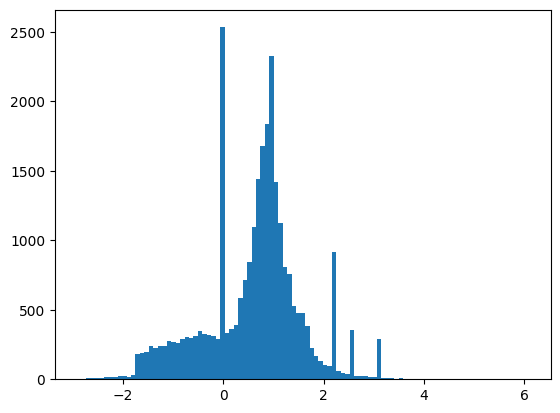

In [10]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)
plt.show()

为了使本教程相对简短，仅使用前 1,000 个样本进行验证，然后使用接下来的 10,000 个样本进行训练：

In [11]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

[`Dataset.skip`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#skip) 和 [`Dataset.take`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) 方法使这很容易。

同时，使用 [`Dataset.cache`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) 方法确保加载器不需要在每个 epoch 重新读取文件中的数据：

In [12]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [13]:
train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

这些数据集返回单个示例。使用 [`Dataset.batch`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) 方法创建适当大小的批次以进行训练。在进行批处理之前，还记得在训练集上使用 [`Dataset.shuffle`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) 和 [`Dataset.repeat`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#repeat)。

In [14]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

## 证明过拟合(Demonstrate overfitting)

防止过拟合的最简单方法是从小模型开始：具有少量可学习参数的模型（由层数和每层的单元数决定）。在深度学习中，模型中可学习参数的数量通常被称为模型的**容量(capacity)**。

直观地说，具有更多参数的模型将具有更多的**记忆能力(memorization capacity)**，因此能够轻松地在训练样本与其目标之间学习完美的字典式映射，这种映射没有任何泛化能力，但这在进行预测时将毫无用处在以前看不见的数据上。

永远记住这一点：**深度学习模型往往擅长拟合训练数据，但真正的挑战是泛化，而不是拟合。**

另一方面，如果网络的记忆资源有限，它就不能那么容易地学习映射。为了最大限度地减少损失，它必须学习具有更强预测能力的压缩表示。同时，如果你的模型太小，它将难以拟合训练数据。 “容量太大”和“容量不足”之间存在平衡。

不幸的是，没有神奇的公式可以确定模型的正确大小或架构（根据层数或每层的正确大小）。您将不得不尝试使用一系列不同的架构。

要找到合适的模型大小，最好从相对较少的层和参数开始，然后开始增加层的大小或添加新层，直到您看到验证损失的回报递减。
> To find an appropriate model size, it's best to start with relatively few layers and parameters , then begin increasing the size of the layers or adding new layers until you see diminishing returns on the validation loss.

从仅使用密集连接层 ([`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) 作为基线的简单模型开始，然后创建更大的模型并进行比较。

### 训练过程(Training procedure)
如果在训练过程中逐渐降低学习率，许多模型的训练效果会更好。使用 [`tf.keras.optimizers.schedules`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules) 随着时间的推移降低学习率：

In [15]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

上面的代码设置了一个 [`tf.keras.optimizers.schedules.InverseTimeDecay`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/InverseTimeDecay) 以双曲线方式在 1,000 个 epoch 时，将学习率降低到基本速率的 1/2，2,000 个 epoch 时降低 1/3，依此类推。
> The code above sets a `tf.keras.optimizers.schedules.InverseTimeDecay` to hyperbolically decrease the learning rate to 1/2 of the base rate at 1,000 epochs , 1/3 at 2,000 epochs, and so on.

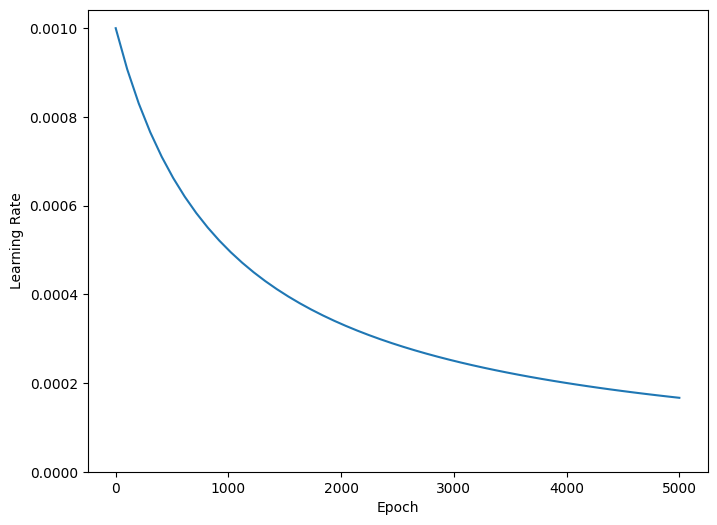

In [16]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')
plt.show()

本教程中的每个模型都将使用相同的训练配置。所以以可重用的方式设置这些，从回调列表开始。

本教程的训练运行了许多短 epoch。要减少日志记录噪音，请使用 `tfdocs.EpochDots` ，对于每个 epoch 它只打印一个 `.`，每 100 个 epoch 有一套完整的指标。

接下来包括 [`tf.keras.callbacks.EarlyStopping`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) 以避免冗长和不必要的训练时间。请注意，此回调设置为监视 `val_binary_crossentropy`，而不是 `val_loss`。这种差异在以后会很重要。

使用 [`callbacks.TensorBoard`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) 为训练生成 TensorBoard 日志。

In [17]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

同样，每个模型都将使用相同的 [`Model.compile`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) 和 [`Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) 设置：

In [18]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

### 微型模型(Tiny model)
从训练模型开始：

In [19]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [20]:
size_histories = {}

In [21]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                464       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5091,  binary_crossentropy:0.8740,  loss:0.8740,  val_accuracy:0.4620,  val_binary_crossentropy:0.8417,  val_loss:0.8417,  
....................................................................................................
Epoch: 100, accuracy:0.5977,  binary_crossentropy:0.6280,  loss:0.6280,  val_accuracy:0.5830,  val_binary_crossentropy:0.6297,  val_loss:0.6297,  
............................................................

现在检查模型是如何做的：

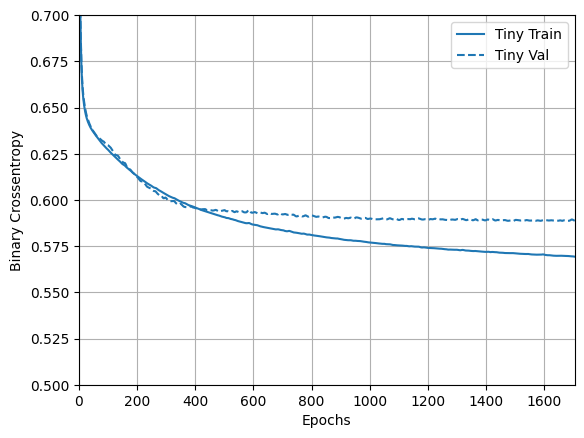

In [22]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])
plt.show()

### 小模型(Small model)
要检查您是否可以超越小型模型的性能，请逐步训练一些较大的模型。

尝试两个隐藏层，每个隐藏层 16 个单元：

In [23]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [24]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                464       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4775,  binary_crossentropy:0.7499,  loss:0.7499,  val_accuracy:0.4710,  val_binary_crossentropy:0.7128,  val_loss:0.7128,  
....................................................................................................
Epoch: 100, accuracy:0.6321,  binary_crossentropy:0.6091,  loss:0.6091,  

### 中等模型(Medium model)
现在尝试三个隐藏层，每个隐藏层有 64 个单元：

In [25]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

并使用相同的数据训练模型：

In [26]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                1856      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4939,  binary_crossentropy:0.7083,  loss:0.7083,  val_accuracy:0.5160,  val_binary_crossentropy:0.6813,  val_loss:0.6813,  
....................................

### 大模型(Large model)

作为练习，您可以创建一个更大的模型并检查它开始过度拟合的速度。接下来，在这个基准中添加一个容量更大的网络，远远超过问题的保证：

In [27]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

并且，再次使用相同的数据训练模型：

In [28]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 512)               14848     
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 dense_11 (Dense)            (None, 512)               262656    
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 dense_13 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5038,  binary_crossentropy

### 绘制训练和验证损失(Plot the training and validation losses)

实线表示训练损失，虚线表示验证损失（请记住：验证损失越低表示模型越好）。

虽然构建更大的模型会赋予它更多的权力，但如果这种权力不受某种限制，它很容易过度拟合到训练集。

在这个例子中，通常只有微型模型能够完全避免过度拟合，并且每个较大的模型都会更快地过度拟合数据。这对于大模型来说变得如此严重，以至于您需要将绘图切换到对数尺度才能真正弄清楚发生了什么。

如果您绘制并将验证指标与训练指标进行比较，这一点很明显。

- 有一点点差异是正常的。
- 如果两个指标都朝着同一个方向发展，那么一切都很好。
- 如果验证指标开始停滞，而训练指标继续提高，则您可能接近过度拟合。
- 如果验证指标朝着错误的方向发展，则模型显然是过拟合的。

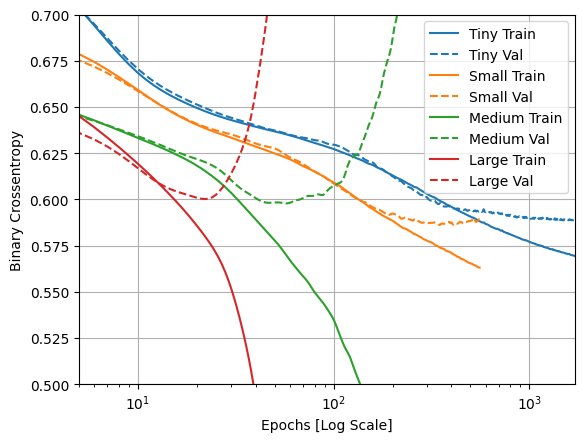

In [29]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")
plt.show()

> 注意：上述所有训练运行都使用 [`callbacks.EarlyStopping`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) 来结束训练，一旦明确模型没有取得进展。

### 在 TensorBoard 中查看

这些模型都在训练期间写入了 TensorBoard 日志。

在 notebook 中打开嵌入式 TensorBoard 查看器：

In [ ]:
#docs_infra: no_execute

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes

您可以在 [TensorBoard.dev](https://tensorboard.dev/) 上查看此笔记本[之前运行的结果](https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97)。

TensorBoard.dev 是托管、跟踪和与所有人共享 ML 实验的托管体验。

为方便起见，它也包含在 `<iframe>` 中：

In [ ]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")

如果您想分享 TensorBoard 结果，您可以通过将以下内容复制到代码单元中来将日志上传到 [`TensorBoard.dev`](https://tensorboard.dev/)。

> 注意：此步骤需要 Google 帐户。

```shell
!tensorboard dev upload --logdir  {logdir}/sizes
```

> 注意：此命令不会终止。它旨在不断上传长期运行的实验结果。上传数据后，您需要使用笔记本工具中的“中断执行”选项停止它。

## 防止过拟合的策略

在进入本节内容之前，请从上面的微模型中复制训练日志，用作比较的基准。

In [32]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/tmp/tmp5fupbcjv/tensorboard_logs/regularizers/Tiny')

In [33]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

### 添加权重正则化(Add weight regularization)

您可能熟悉奥卡姆剃刀原理：对于某事给出两种解释，最有可能正确的解释是“最简单”的一种，即做出最少假设的一种。这也适用于神经网络学习的模型：给定一些训练数据和网络架构，有多组权重值（多个模型）可以解释数据，与复杂模型相比，更简单的模型不太可能过度拟合。

在这种情况下，“简单模型”是参数值分布具有较少熵的模型（或完全具有较少参数的模型，如上一节所示）。因此，减轻过拟合的一种常见方法是通过强制其权重仅取较小的值来限制网络的复杂性，这使得权重值的分布更加“规则”。这被称为“权重正则化(weight regularization)”，它是通过向网络的损失函数添加与具有大权重相关的成本来完成的。这笔费用有两种形式：

- [L1 正则化(L1 regularization)](https://developers.google.com/machine-learning/glossary/#L1_regularization)，其中增加的成本与权重系数的绝对值成正比（即权重的所谓“L1范数”）。
- [L2 正则化(L2 regularization)](https://developers.google.com/machine-learning/glossary/#L2_regularization)，其中增加的成本与权重系数值的平方成正比（即权重的平方“L2范数”）。 L2 正则化在神经网络的上下文中也称为权重衰减。不要让不同的名称让您感到困惑：权重衰减在数学上与 L2 正则化完全相同。

L1 正则化将权重推向恰好为零，从而鼓励稀疏模型。 L2 正则化将惩罚权重参数而不使它们变得稀疏，因为小权重的惩罚为零——这也是 L2 更常见的一个原因。

在 [`tf.keras`](https://www.tensorflow.org/api_docs/python/tf/keras) 中，通过将权重正则化器实例作为关键字参数传递给层来添加权重正则化。添加 L2 权重正则化：

In [34]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 512)               14848     
                                                                 
 dense_15 (Dense)            (None, 512)               262656    
                                                                 
 dense_16 (Dense)            (None, 512)               262656    
                                                                 
 dense_17 (Dense)            (None, 512)               262656    
                                                                 
 dense_18 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5105,  binary_crossentropy

`l2(0.001)` 表示该层权重矩阵中的每个系数都会将 `0.001 * weight_coefficient_value**2` 添加到网络的总损失中。

这就是我们直接监控 `binary_crossentropy` 的原因。因为它没有混入这个正则化组件。

因此，具有 L2 正则化惩罚的相同大模型表现得更好：

> 这...执行结果看起来并不怎么好呀...

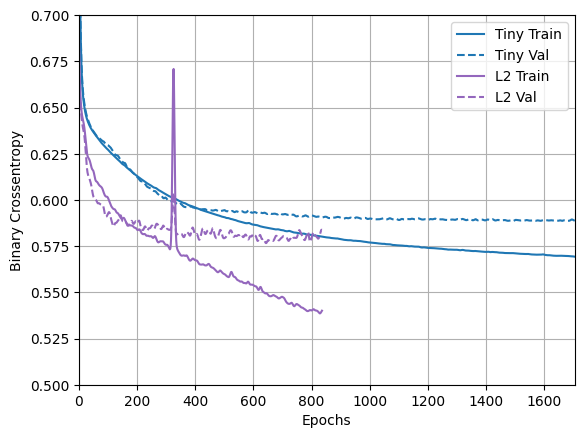

In [35]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])
plt.show()

如上图所示，`L2`正则化模型现在比`Tiny`模型更具竞争力。尽管具有相同数量的参数，但这个`L2`模型也比它所基于的`Large`模型更能抵抗过度拟合。

#### 更多信息

关于这种正则化有两点需要注意：

1. 如果您正在编写自己的训练循环，那么您需要确保向模型询问其正则化损失。

In [36]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

2. 该实现通过将权重惩罚添加到模型的损失中，然后在此之后应用标准优化程序来工作。

还有第二种方法，它只在原始损失上运行优化器，然后在应用计算步骤时，优化器还应用一些权重衰减。这种“解耦权重衰减”用于 [`tf.keras.optimizers.Ftrl`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Ftrl) 和 [`tfa.optimizers.AdamW`](https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers/AdamW) 等优化器。

### 添加 dropout

Dropout 是神经网络最有效和最常用的正则化技术之一，由 Hinton 和他在多伦多大学的学生开发。

对 dropout 的直观解释是，由于网络中的各个节点不能依赖其他节点的输出，因此每个节点都必须输出对自己有用的特征。

应用于层的 Dropout 包括在训练期间随机“丢弃”（即设置为零）该层的一些输出特征。例如，给定的层通常会在训练期间为给定的输入样本返回一个向量 `[0.2, 0.5, 1.3, 0.8, 1.1]`；应用 dropout 后，此向量将随机分布一些零条目，例如 `[0, 0.5, 1.3, 0, 1.1]`。

“dropout rate”是被归零的特征的比例；它通常设置在 0.2 和 0.5 之间。在测试时，没有单元被丢弃，而是层的输出值被缩小一个等于丢弃率的因子，以平衡更多单元比训练时活跃的事实。

在 Keras 中，您可以通过 [`tf.keras.layers.Dropout`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) 层在网络中引入 dropout，该层会在之前应用于层的输出。

向您的网络添加两个 dropout 层，以检查它们在减少过度拟合方面的效果：

In [37]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 512)               14848     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_20 (Dense)            (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_21 (Dense)            (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 512)              

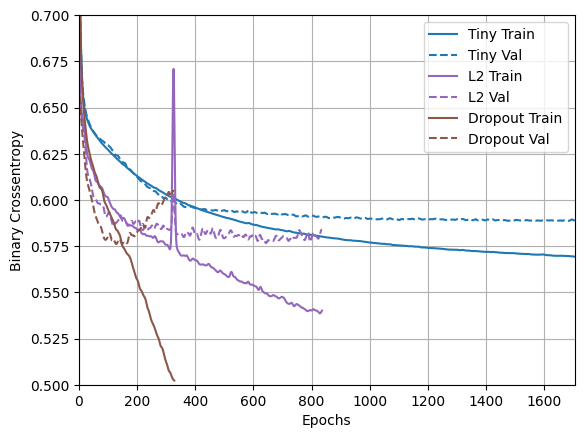

In [38]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])
plt.show()

从该图中可以清楚地看出，这两种正则化方法都改善了 `"Large"` 模型的行为。但这仍然没有超过 `"Tiny"` 基线。

接下来，一起尝试它们，看看是否效果更好。

### 整合 L2 + 辍学(Combined L2 + dropout)

In [39]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 512)               14848     
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_25 (Dense)            (None, 512)               262656    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_26 (Dense)            (None, 512)               262656    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_27 (Dense)            (None, 512)              

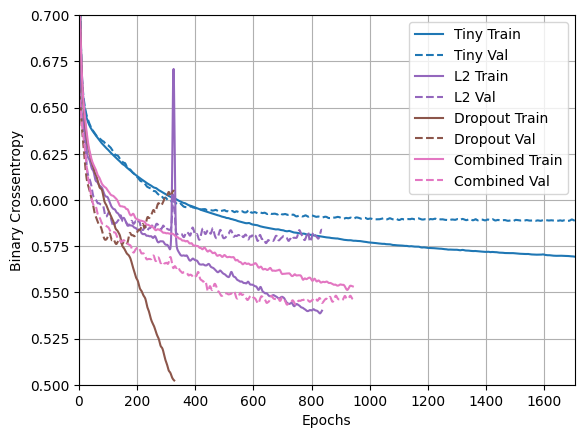

In [40]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])
plt.show()

这种具有`“整合(Combined)”`正则化的模型显然是迄今为止最好的模型。

### 在 TensorBoard 中查看

这些模型还记录了 TensorBoard 日志。

要在 notebook 中打开嵌入式张量板查看器，请将以下内容复制到代码单元中：

```shell
%tensorboard --logdir {logdir}/regularizers
```

您可以在 [TensorBoard.dev](https://tensorboard.dev/) 上查看此笔记本[之前运行的结果](https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97)。

为方便起见，它也包含在 `<iframe>` 中：

In [ ]:
display.IFrame(
    src="https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97",
    width = "100%",
    height="800px")

这是通过以下方式上传的：

```shell
!tensorboard dev upload --logdir  {logdir}/regularizers
```

## 结论

回顾一下，以下是防止神经网络过度拟合的最常见方法：

- 获取更多训练数据。
- 降低网络容量。
- 添加权重正则化。
- 添加辍学。

本指南未涵盖的两种重要方法是：

- [数据增强](https://www.tensorflow.org/tutorials/images/data_augmentation)
- 批量标准化([`tf.keras.layers.BatchNormalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization))

请记住，每种方法都可以单独提供帮助，但通常将它们结合起来会更有效。